In [1]:
from sys import platform as _platform
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
#if _platform =='linux2':
#    path = '../data/data_sleep/' 
#else:
#    #mets ton path ici et ça devrait marcher :)
#    path = ""
import theano
import theano.tensor as T

import lasagne
path = "./data/"

theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [2]:
#frequencies=pd.read_csv(path+"data_frequences.csv").drop("Unnamed: 0", axis=1)
frequencies=pd.read_csv(path+"fft_eeg.csv")
frequencies_acc =pd.read_csv(path+"fft_acc.csv", index_col="ID")

stats=pd.read_csv(path+"data_stat_feats.csv").drop("Unnamed: 0", axis=1)
labels=pd.read_csv(path+"challenge_output_data_training_file_sleep_stages_classification.csv", sep=";")

In [3]:
def select_freq_names(low, high, X_columns, prefix = ''):
    return [name for name in X_columns 
            if len(name.split('q'))==2 
            and name.split('freq')[0] == prefix
            and low<=float(name.split('freq')[1]) 
            and high>= float(name.split('freq')[1])]
def group_frequencies(name, low, high, frequencies, prefix = ''):
    frequencies[name]=(1./(high-low) * (frequencies[select_freq_names(low,high,frequencies.columns,prefix)])).sum(axis=1)

In [4]:
new_feat = ["delta", 'theta', 'alpha1','alpha2', 'beta']
#frequencies["delta"]=frequencies[select_freq_names(0,3,frequencies.columns)].sum(axis=1)
#frequencies["delta"]=frequencies[select_freq_names(0,3.99,frequencies.columns)].sum(axis=1)
#frequencies["theta"]=frequencies[select_freq_names(4,7.5,frequencies.columns)].sum(axis=1)
#frequencies["alpha"]=frequencies[select_freq_names(7.5,13.99,frequencies.columns)].sum(axis=1)
#frequencies["beta"]=frequencies[select_freq_names(14,50,frequencies.columns)].sum(axis=1)

def make_new_feats(frequencies):
    group_frequencies("delta", 0.8, 3.99, frequencies)
    group_frequencies("theta", 4, 7.499, frequencies)
    group_frequencies("alpha1", 7.5, 9.5, frequencies)
    group_frequencies("alpha2", 9.5, 13.99, frequencies)
    group_frequencies("beta", 14, 50, frequencies)
#make_new_feats(frequencies)

In [5]:
from sklearn.cross_validation import train_test_split
def train_val_test_split(X):    
    X_train, X_test = train_test_split(X, test_size=0.10, random_state=42)
    X_train, X_val = train_test_split(X_train, test_size=0.10, random_state=42)
    return X_train, X_val, X_test

In [6]:
X_ACC_train, X_ACC_val, X_ACC_test=train_val_test_split(frequencies_acc)
X_EEG_train, X_EEG_val, X_EEG_test=train_val_test_split(frequencies)
X_other_train, X_other_val, X_other_test=train_val_test_split(stats.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z"], axis=1))
y_train, y_val, y_test=train_val_test_split(labels["TARGET"])

In [7]:
from sklearn.preprocessing import StandardScaler


scaler_ACC_train = StandardScaler().fit(X_ACC_train)
scaler_EEG_train= StandardScaler().fit(X_EEG_train)
scaler_other_train=StandardScaler().fit(X_other_train)
"""
scaler_ACC_predict = StandardScaler().fit(X_ACC)
scaler_EEG_predict= StandardScaler().fit(X_EEG)
"""

X_ACC_train=scaler_ACC_train.transform(X_ACC_train)
X_ACC_val=scaler_ACC_train.transform(X_ACC_val)
X_ACC_test=scaler_ACC_train.transform(X_ACC_test)

X_EEG_train=scaler_EEG_train.transform(X_EEG_train)
X_EEG_val=scaler_EEG_train.transform(X_EEG_val)
X_EEG_test=scaler_EEG_train.transform(X_EEG_test)

X_other_train=scaler_other_train.transform(X_other_train)
X_other_val=scaler_other_train.transform(X_other_val)
X_other_test=scaler_other_train.transform(X_other_test)

"""
X_ACC=scaler_ACC_predict.transform(X_ACC)
X_EEG=scaler_EEG_predict.transform(X_EEG)

X_ACC_TEST=scaler_ACC_predict.transform(X_ACC_TEST)
X_EEG_TEST=scaler_EEG_predict.transform(X_EEG_TEST)
"""

'\nX_ACC=scaler_ACC_predict.transform(X_ACC)\nX_EEG=scaler_EEG_predict.transform(X_EEG)\n\nX_ACC_TEST=scaler_ACC_predict.transform(X_ACC_TEST)\nX_EEG_TEST=scaler_EEG_predict.transform(X_EEG_TEST)\n'

In [8]:
labels_num=pd.DataFrame([range(len(y_train)), list(y_train)], index=["ID","y"]).T.groupby("y").count()

In [9]:
def extra_sample(label, X_EEG_train, X_ACC_train, X_other_train):
    random_indices=np.random.randint(0,labels_num.loc[label], labels_num.max()-labels_num.loc[label])
    EEG=X_EEG_train[random_indices]
    ACC=X_ACC_train[random_indices]
    other=X_other_train[random_indices]
    return EEG, ACC, other

In [10]:
X_EEG_train_l=(X_EEG_train,)
X_ACC_train_l=(X_ACC_train,)
X_other_train_l=(X_other_train,)
for label in labels["TARGET"].unique():
    if (labels_num.iloc[label].values < labels_num.max())[0]:
        sample=extra_sample(label, X_EEG_train, X_ACC_train, X_other_train)
        X_EEG_train_l=X_EEG_train_l + (sample[0],)
        X_ACC_train_l=X_ACC_train_l + (sample[1],)
        X_other_train_l=X_other_train_l + (sample[2],)
X_EEG_trs=np.concatenate(X_EEG_train_l, axis=0)
X_ACC_trs=np.concatenate(X_ACC_train_l, axis=0)
X_other_trs=np.concatenate(X_other_train_l, axis=0)
y_trs=np.concatenate(
    (y_train,) + tuple(
        [np.array([label]*(labels_num.max()-labels_num.loc[label])[0]) for label in labels["TARGET"].unique()]
                      )
    )

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:1198: FutureWarning: scalar indexers for index type Float64Index should be integers and not floating point
  return self._getitem_axis(key, axis=0)


In [11]:
def regroup_acc_freq (frequencies_acc):
    for prefix in ['ACC_X.','ACC_Y.','ACC_Z.']:
        group_frequencies(prefix+"smaller_one",0.01,1, frequencies_acc,prefix)
        group_frequencies(prefix+"one_to_two",1.01,2, frequencies_acc,prefix)
        group_frequencies(prefix+"two_to_three",2.01,3, frequencies_acc,prefix)
        group_frequencies(prefix+"three_to_four",3.01,4, frequencies_acc,prefix)
        group_frequencies(prefix+"more_four",4,10, frequencies_acc,prefix)
#regroup_acc_freq (frequencies_acc)

#prefixes = ['ACC_X.','ACC_Y.','ACC_Z.']
#frequencies_acc = frequencies_acc[[prefix+ x for x in["smaller_one","one_to_two","two_to_three",'more_four']for prefix in prefixes]]

In [12]:
def reshape(X, n_channels):
    return X.reshape(X.shape[0],n_channels,X.shape[1]/n_channels)

In [13]:
X_ACC_trs=reshape(X_ACC_trs,3)
X_ACC_val=reshape(X_ACC_val,3)
X_ACC_test=reshape(X_ACC_test,3)

X_EEG_trs=reshape(X_EEG_trs,1)
X_EEG_val=reshape(X_EEG_val,1)
X_EEG_test=reshape(X_EEG_test,1)

X_other_trs=reshape(X_other_trs,1)
X_other_val=reshape(X_other_val,1)
X_other_test=reshape(X_other_test,1)

In [14]:
# Prepare Theano variables for inputs and targets
input_var_EEG = T.tensor3('inputs')
input_var_ACC = T.tensor3('inputs')
input_var_other = T.tensor3('inputs')
target_var = T.ivector('targets')
# Create neural network model

In [16]:
import time
from sklearn.base import BaseEstimator
def iterate_minibatches(
    input_1, 
    input_2, 
    input_3,
    targets, 
    batchsize, 
    shuffle=False
):
    assert len(input_1) == len(targets)
    assert len(input_2) == len(targets)
    assert len(input_3) == len(targets)
    if shuffle:
        indices = np.arange(len(input_1))
        np.random.shuffle(indices)
    for start_idx in range(0, len(input_1) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield input_1[excerpt], input_2[excerpt], input_3[excerpt], targets[excerpt]

"""Default variables"""
num_epochs = 20
EEG_shape_1=X_EEG_trs.shape[1]
EEG_shape_2=X_EEG_trs.shape[2]
ACC_shape_1=X_ACC_trs.shape[1]
ACC_shape_2=X_ACC_trs.shape[2]
other_shape_1=X_other_trs.shape[1]
other_shape_2=X_other_trs.shape[2]
n_filters_EEG_1=32
n_filters_EEG_2=32
n_filters_ACC_1=16
n_filters_ACC_2=16
filter_size_EEG_1=32
filter_size_EEG_2=8
filter_size_ACC_1=8
filter_size_ACC_2=4
pool_size_EEG_1=16
pool_size_EEG_2=4
pool_size_ACC_1=16
pool_size_ACC_2=4
drop_out=0.5
init_learning_rate=0.01
num_units_EEG=1000
num_units_ACC=100
num_units_concat=2000
num_units_other=1000
num_classes=5

class CNN(BaseEstimator):
    def __init__(
        self,
        input_var_EEG, 
        input_var_ACC,
        input_var_other,
        target_var,
        num_epochs
    ):
        #setting variables
        self.input_var_EEG=input_var_EEG
        self.input_var_ACC=input_var_ACC
        self.input_var_other=input_var_other
        self.target_var=target_var    
        self.num_epochs=num_epochs
        
        #The network
        #Three initialisation layers
        #One for EEG
        self.l_in1 = lasagne.layers.InputLayer(
            shape=(None,EEG_shape_1, EEG_shape_2),
            input_var=self.input_var_EEG
        )
        #One for ACC
        self.l_in2 = lasagne.layers.InputLayer(
            shape=(None,ACC_shape_1, ACC_shape_2),
            input_var=self.input_var_ACC
        )
        self.l_in3=lasagne.layers.InputLayer(
            shape=(None,other_shape_1, other_shape_2),
            input_var=self.input_var_other
        )
        #Two convolutional layers to treat each signal separatedly
        self.l_conv1_1 = lasagne.layers.Conv1DLayer(
            self.l_in1, 
            num_filters=n_filters_EEG_1, 
            filter_size=filter_size_EEG_1,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotNormal()
        )
        self.l_conv2_1 = lasagne.layers.Conv1DLayer(
            self.l_in2, 
            num_filters=n_filters_ACC_1, 
            filter_size=filter_size_ACC_1,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotNormal()
        )
        #And two pooling layers

        self.l_pool_1_1 = lasagne.layers.MaxPool1DLayer(
            self.l_conv1_1, 
            pool_size=pool_size_EEG_1
        )
        self.l_pool_2_1 = lasagne.layers.MaxPool1DLayer(
            self.l_conv2_1, 
            pool_size=pool_size_ACC_1
        )
        #And again another 2 layers
        self.l_conv1_2 = lasagne.layers.Conv1DLayer(
            self.l_pool_1_1, 
            num_filters=n_filters_EEG_2, 
            filter_size=filter_size_EEG_2,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform()
        )
        self.l_conv2_2 = lasagne.layers.Conv1DLayer(
            self.l_conv2_1, num_filters=16, filter_size=5,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform())
        #pool
        self.l_pool_1_2 = lasagne.layers.MaxPool1DLayer(
            self.l_conv1_2, 
            pool_size=pool_size_EEG_2
        )
        self.l_pool_2_2 = lasagne.layers.MaxPool1DLayer(
            self.l_conv2_2, 
            pool_size=pool_size_ACC_2
        )
        #Dense layer for "others" :
        self.l_dense_other = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(
                self.l_in3, 
                p=drop_out
            ),
            num_units=num_units_other,
            nonlinearity=lasagne.nonlinearities.rectify
        )
        #Two dense layers for each signal
        self.l_dense_1_1 = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(
                self.l_pool_1_2, 
                p=drop_out
            ),
            num_units=num_units_EEG,
            nonlinearity=lasagne.nonlinearities.rectify
        )
        self.l_dense_2_1 = lasagne.layers.DenseLayer(
                lasagne.layers.dropout(
                self.l_pool_2_2, 
                p=drop_out
            ),
            num_units=num_units_ACC,
            nonlinearity=lasagne.nonlinearities.rectify
        )
        #use neurons from both signals to predict
        #concatenate neurons
        self.l_concat = lasagne.layers.ConcatLayer(
            [
                #self.l_pool_1_2, 
                #self.l_pool_2_2,
                self.l_dense_1_1,
                self.l_dense_2_1,
                self.l_dense_other
            ], 
            axis=1
        )
        #dense layer with all neurons
        self.l_dense_2 = lasagne.layers.DenseLayer(
                lasagne.layers.dropout(
                self.l_concat, 
                p=drop_out
            ),
            num_units=num_units_concat,
            nonlinearity=lasagne.nonlinearities.rectify
        )
        #Output layer
        self.l_output = lasagne.layers.DenseLayer(
            lasagne.layers.dropout(
                self.l_dense_2, 
                #self.l_pool_1_2,
                p=drop_out
            ),
            num_units=num_classes,
            nonlinearity=lasagne.nonlinearities.softmax
        )
        self.prediction = lasagne.layers.get_output(self.l_output)
        self.loss = lasagne.objectives.multiclass_hinge_loss(self.prediction, target_var)
        self.loss = self.loss.mean()
        self.params = lasagne.layers.get_all_params(self.l_output, trainable=True)
        self.updates = lasagne.updates.adadelta(
            self.loss, 
            self.params, 
            learning_rate=init_learning_rate
        )
        self.test_prediction = lasagne.layers.get_output(self.l_output, deterministic=True)
        self.test_loss = lasagne.objectives.multiclass_hinge_loss(self.test_prediction,
                                                                target_var)
        self.test_loss = self.test_loss.mean()
        self.test_acc = T.mean(T.eq(T.argmax(self.test_prediction, axis=1), self.target_var),
                  dtype=theano.config.floatX)
        self.train_fn =theano.function(
            [
                self.input_var_EEG, 
                self.input_var_ACC,
                self.input_var_other,
                self.target_var
            ], 
            self.loss, 
            updates=self.updates
        )
        self.val_fn = theano.function(
            [
                self.input_var_EEG, 
                self.input_var_ACC,
                self.input_var_other,
                self.target_var
            ], 
            [self.test_loss, self.test_acc])
    def fit(
        self,X_EEG_train,
        X_ACC_train,
        X_other_train,
        X_EEG_val,
        X_ACC_val,
        X_other_val,
        y_train,
        y_val
    ):

        for epoch in range(self.num_epochs):
            # In each epoch, we do a full pass over the training data:
            train_err = 0
            train_batches = 0
            start_time = time.time()
            for batch in iterate_minibatches(
                X_EEG_train, 
                X_ACC_train, 
                X_other_train,
                y_train, 
                64, 
                shuffle=True
            ):
                input_1, input_2, input_3, targets = batch
                #inputs, targets = batch
                targets = targets.astype(np.int32)
                train_err += self.train_fn(input_1, input_2, input_3, targets)
                #train_err += self.train_fn(inputs, targets)
                train_batches += 1
                if train_batches % 100 == 0:
                    print "epoch {}, train batches{}".format(epoch,train_batches) 

            # And a full pass over the validation data:
            val_err = 0
            val_acc = 0
            val_batches = 0
            for batch in iterate_minibatches(
                X_EEG_val, 
                X_ACC_val, 
                X_other_val,
                y_val, 
                128, 
                shuffle=False
            ):
                input_1, input_2, input_3, targets = batch
                #inputs, targets = batch
                targets = targets.astype(np.int32)
                err, acc = self.val_fn(input_1, input_2, input_3, targets)
                #err, acc = self.val_fn(inputs, targets)
                val_err += err
                val_acc += acc
                val_batches += 1

            # Then we print the results for this epoch:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
            print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
            print("  validation accuracy:\t\t{:.2f} %".format(
                val_acc / val_batches * 100))
        return self
        
    def predict_proba(
        self,
        X_EEG_test, 
        X_ACC_test,
        X_other_test
    ):
        net_output=lasagne.layers.get_output(self.l_output, deterministic=True)
        prediction_fn = theano.function(
            [
                input_var_EEG, 
                input_var_ACC,
                input_var_other
            ], 
            [net_output]
        )
        prediction =  prediction_fn(
            X_EEG_test, 
            X_ACC_test,
            X_other_test
        )
        return prediction[0]

    def predict(
        self,
        X_EEG_test, 
        X_ACC_test,
        X_other_test
    ):
         return np.argmax(self.predict_proba(
                    X_EEG_test, 
                    X_ACC_test,
                    X_other_test
                ), axis=1)
        

In [ ]:
cnn=CNN(input_var_EEG,
        input_var_ACC,
        input_var_other,
        target_var,
        num_epochs
       )

In [ ]:
cnn.fit(
    X_EEG_trs,
    X_ACC_trs,
    X_other_trs,
    X_EEG_val,
    X_ACC_val,
    X_other_val,
    y_trs,
    y_val
)

epoch 0, train batches100
epoch 0, train batches200
epoch 0, train batches300
epoch 0, train batches400
epoch 0, train batches500
epoch 0, train batches600
epoch 0, train batches700
epoch 0, train batches800
epoch 0, train batches900
Epoch 1 of 20 took 485.890s
  training loss:		1.070876
  validation loss:		0.997366
  validation accuracy:		51.56 %
epoch 1, train batches100
epoch 1, train batches200
epoch 1, train batches300
epoch 1, train batches400
epoch 1, train batches500
epoch 1, train batches600
epoch 1, train batches700
epoch 1, train batches800
epoch 1, train batches900
Epoch 2 of 20 took 441.318s

In [ ]:
probas=cnn.predict_proba(X_test)

In [ ]:
probas

In [105]:
predictions=cnn.predict(X_EEG_test, X_ACC_test, X_other_test)

In [106]:
import collections
print collections.Counter(y_test), collections.Counter(predictions)

Counter({2.0: 1537, 3.0: 945, 4.0: 438, 0.0: 151, 1.0: 42}) Counter({2: 2071, 3: 1042})


In [109]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, [0,1,2,3,4], rotation=45)
    plt.yticks(tick_marks, [0,1,2,3,4])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


 [[   0    0  130   21    0]
 [   0    0   41    1    0]
 [   0    0 1238  299    0]
 [   0    0  233  712    0]
 [   0    0  429    9    0]]


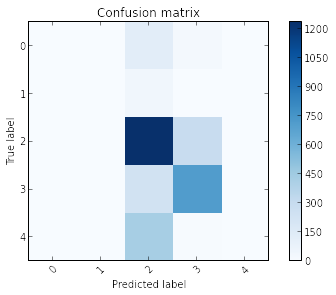

In [111]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, predictions)
print cm
plt.figure()
plot_confusion_matrix(cm)
